In [0]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!rm crawl*
!rm wget-log
!wget -v https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M-subword.zip
!unzip crawl-300d-2M-subword.zip -d fasttext/

rm: cannot remove 'crawl*': No such file or directory
rm: cannot remove 'wget-log': No such file or directory
--2018-11-13 14:04:46--  https://s3-us-west-1.amazonaws.com/fasttext-vectors/crawl-300d-2M-subword.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 54.231.235.29
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|54.231.235.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

crawl-300d-2M-subwo 100%[===================>]   5.43G  72.4MB/s    in 84s     

2018-11-13 14:06:11 (65.8 MB/s) - ‘crawl-300d-2M-subword.zip’ saved [5828358084/5828358084]

Archive:  crawl-300d-2M-subword.zip
  inflating: fasttext/crawl-300d-2M-subword.vec  
  inflating: fasttext/crawl-300d-2M-subword.bin  


In [0]:
!pip3 install -q keras

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip3 install gensim
!pip3 install nltk
!pip3 install cython
!pip3 install pyfasttext

In [0]:
import numpy as np 
import pandas as pd
import csv
from gensim.models import KeyedVectors
from pyfasttext import FastText
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import nltk
import string
import re
import gzip
from sklearn.model_selection import train_test_split

%matplotlib inline



In [0]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
base_dir = 'drive/My Drive/btp/'
data_dir = base_dir
# embedding_file = base_dir + 'GoogleNews-vectors-negative300.bin.gz'
embedding_file = 'fasttext/crawl-300d-2M-subword.bin'

health_data_dir = base_dir + 'reviews_Health_and_Personal_Care_5.json.gz'
elec_data_dir = base_dir + 'reviews_Electronics_5.json.gz'

NUM_TOT = 10

data = "elec"

In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [0]:
my_vocab = []

# https://www.kaggle.com/currie32/the-importance-of-cleaning-text
def preprocess_text(text):

    text = re.sub(r'\'s', ' is', text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"(?P<num>\d+)k", r'\g<num>000', text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r" \d+ ", " number ", text)
    text = re.sub(r'([^A-Za-z0-9])', r' \1 ', text)
    
    return text

def build_vocab_and_preprocess(X, remove_stopwords = False, remove_punctuation = True, lowercase = False):
    
    punc = string.punctuation
    stopwords = list(set(nltk.corpus.stopwords.words('english')))
    
    modified_X = []
    
    for i in range(X.shape[0]):
        sent = X[i, 0]
        if len(sent) < 1 :
            sent = ''
        
        sent = preprocess_text(sent)
        
        words = nltk.word_tokenize(sent)
        words = [i for i in words if len(i) > 3]
        if remove_punctuation:
            words = [i for i in words if i not in punc]
        if lowercase:
            words = [i.lower() for i in words]
        if remove_stopwords:
            words = [i for i in words if i not in stopwords]
        my_vocab.extend(words)
       
        modified_X.append(words)
    
    return modified_X
        
    

In [0]:
def get_data():
    if data == "health":
        data_df = getDF(health_data_dir)
    else:
        data_df = getDF(elec_data_dir)
    
    ratings = data_df.overall.values
    ratings = ratings.reshape((ratings.shape[0],1))

    help_tuple = data_df.helpful.values
    help_tuple = help_tuple.reshape((help_tuple.shape[0],1))
    help_matrix = (np.asarray([np.asarray(t[0]) for t in help_tuple])).astype('float')
    help_matrix[:,0] = help_matrix[:,0] / help_matrix[:,1]

    rev_text = data_df.reviewText.values
    rev_text = rev_text.reshape((rev_text.shape[0],1))

    indices = np.logical_and(help_matrix[:,1] >= NUM_TOT, help_matrix[:,0] >= 0.1)
    indices = np.logical_and(indices, help_matrix[:,0] <= 0.8)
    ratings = ratings[indices]
    rev_text = rev_text[indices]
    help_matrix = np.expand_dims(((help_matrix[indices])[:,0]), axis = 1)
    
    rev_text = build_vocab_and_preprocess(rev_text, remove_stopwords=True,
                                          remove_punctuation= True, lowercase=True)
     
    
    return ratings, rev_text, help_matrix

    

In [0]:
ratings, rev_text, help_matrix = get_data()

print(ratings.shape)
print(ratings[:3,:])

print(len(rev_text))
print(rev_text[:3])

print(help_matrix.shape)
print(help_matrix[:3,:])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


(30724, 1)
[[1.]
 [5.]
 [1.]]
30724
[['professional', 'truck', 'driver', 'bought', 'number', 'truck', 'stop', 'hoping', 'make', 'life', 'easier', 'rand', 'mcnally', 'listening', 'first', 'thing', 'charging', 'connect', 'laptop', 'install', 'software', 'attempt', 'update', 'software', 'detected', 'problem', 'update', 'wanted', 'home', 'address', 'could', 'sent', 'patch', 'card', 'hello', 'think', 'unusual', 'home', 'address', 'friend', 'checks', 'weekly', 'might', 'check', 'every', 'months', 'live', 'truck', 'truck', 'stops', 'need', 'make', 'patch', 'available', 'card', 'send', 'cards', 'truck', 'stops', 'devices', 'sold', 'update', 'program', 'multiple', 'times', 'program', 'said', 'number', 'completely', 'updated', 'programmed', 'height', 'length', 'weight', 'told', 'preferred', 'highways', 'parked', 'truck', 'stop', 'cincinnati', 'area', 'next', 'pickup', 'number', 'miles', 'freeway', 'side', 'couple', 'blocks', 'cell', 'phone', 'sprint', 'said', 'freeway', 'pickup', 'number', 'rout

(array([1743., 1768., 1918., 1532., 1794., 2217., 2335., 3316., 5703.,
        8398.]),
 array([0.1 , 0.17, 0.24, 0.31, 0.38, 0.45, 0.52, 0.59, 0.66, 0.73, 0.8 ]),
 <a list of 10 Patch objects>)

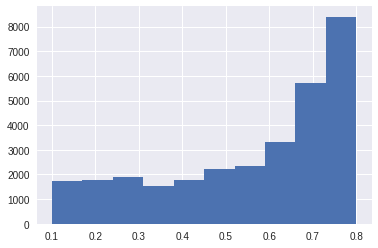

In [0]:
plt.hist(help_matrix)


In [0]:
my_vocab = list(set(my_vocab))
print(len(my_vocab))

word_to_index = {}
index_to_word = {}
i = 1
for word in my_vocab:
    word_to_index[word] = i
    index_to_word[i] = word
    i += 1


74191


In [0]:
# print('Loading Word Embeddings \n')

# wordvec = KeyedVectors.load_word2vec_format(embedding_file, binary = True)

# embedding_dim = wordvec.vector_size
# print('Embedding Dimension = ' + str(embedding_dim))

In [0]:
print('Loading Word Embeddings \n')

wordvec = FastText('fasttext/crawl-300d-2M-subword.bin')

embedding_dim = 300
print('Embedding Dimension = ' + str(embedding_dim))

Loading Word Embeddings 

Embedding Dimension = 300


In [0]:
from keras.layers import Embedding

def pretrained_embedding_layer(word_to_index, get_unk = False, fasttext = True):
    
    vocab_len  = len(word_to_index) + 1
    
    embedding_matrix = np.zeros((vocab_len, embedding_dim))
    
    if fasttext == True :
      for word, index in word_to_index.items():
        emb_vec = wordvec.get_numpy_vector(word)
        embedding_matrix[index] = emb_vec
    
    else:
      unk_count = 0
      for word, index in word_to_index.items():
          if word in wordvec.vocab:
              emb_vec = wordvec[word]
              embedding_matrix[index] = emb_vec
          else:
              unk_count += 1

      if get_unk:
        print(unk_count)
    
    embedding_layer = Embedding(vocab_len, embedding_dim, trainable = False, name = 'Embedding_Layer')
    
    embedding_layer.build((None, ))
    
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer        

Using TensorFlow backend.


In [0]:
embedding_layer = pretrained_embedding_layer(word_to_index, get_unk = True)
print(" ", embedding_layer.get_weights()[0][1][3])
embedding_layer = None

  0.0166621


In [0]:
def index_data(X):
    X_temp = []
    for rev in X:
      temp = [word_to_index[i] for i in rev]
      X_temp.append(temp)
    return X_temp

In [0]:
X = index_data(rev_text)


In [0]:
temp = np.asarray([len(i) for i in X])
print(np.min(temp))
print(np.max(temp))
print(np.mean(temp))
print(np.std(temp))


0
2879
108.6619580783752
130.70270021514304


In [0]:
print(np.sum(temp > 200))

4183


In [0]:
from keras.preprocessing.sequence import pad_sequences
max_len = 200

def pad_data(X):
    padded_X = pad_sequences(X, maxlen = max_len, padding = 'post', truncating = 'post')
    return padded_X

In [0]:
X_padded = pad_data(X)

print(X_padded.shape)

print(X_padded[:3, :])

(30724, 200)
[[48960 37153 38002 19625 21653 37153 43977 43324 11095 25493 14918 64808
  65217 54877 33087 54871 62486 57712 72133 38475 38043 25553 28151 38043
  27419 40338 28151  7612 20603 64644 26168  9020 58148 23541 21050 17076
  11648 20603 64644 73773 43386 39844 65025 45560  3679 51938 29994 37153
  37153 34317  5612 11095 58148 68840 23541 16237 57520 37153 34317 46344
  68673 28151 37711 13538 33760 37711 31491 21653 40906 36827 33609 48685
  74172 36001 33644 67617 25734 20346 37153 43977 45575 40441 14264 40406
  21653 20948 49092 38602 32528 54174 13959  2378 48159 31491 49092 40406
  21653 48624  7920 21653 20948 68758 54566 14496 17102 40406  3543 53395
  16176  3679 33663 33945 12083 42616 30757 67843 21653 14191 30304 21653
  34225 23154 21243 46355 13538 33760 42504 62039 51166  8971 10242  7635
  40406 60257 38602 45575 18091 45992 55589 66069 21243 44722 38669 60276
  19551 73230 13959  2378 32288 15987  7612 21243 65383 54566 22791 44975
  25394 38602 44975   959

In [0]:
help_matrix[help_matrix >= 0.6] = 1
help_matrix[help_matrix < 0.6] = 0
rat_train, rat_test, rev_train, rev_test, help_train, help_test = \
train_test_split(ratings, X_padded, help_matrix, test_size=0.2, random_state=1)

rat_train, rat_dev, rev_train, rev_dev, help_train, help_dev = \
train_test_split(rat_train, rev_train, help_train, test_size = 0.2, random_state=1)

0.5628846056044348


(array([ 8595.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11068.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

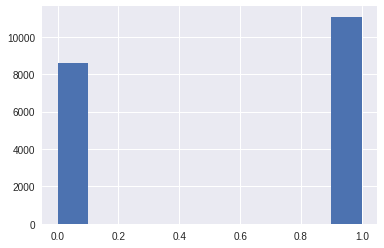

In [0]:
print(np.sum(help_train)/ help_train.shape[0])
plt.hist(help_train)

0.5617575264442636


(array([2693.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3452.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

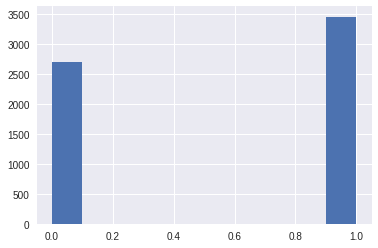

In [0]:
print(np.sum(help_test)/ help_test.shape[0])
plt.hist(help_test)

0.5685516680227828


(array([2121.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2795.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

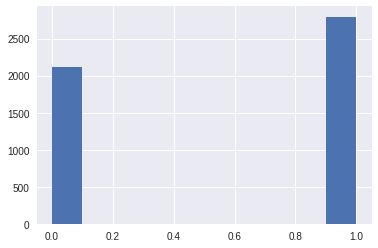

In [0]:
print(np.sum(help_dev)/ help_dev.shape[0])
plt.hist(help_dev)

In [0]:
np.random.seed(0)
from keras.models import Model, load_model
from keras.layers import Input, CuDNNLSTM, Activation, Lambda, Dense, Dropout, Bidirectional, BatchNormalization
from keras import backend as K
from keras import optimizers, regularizers, initializers
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import time

In [0]:
INPUT_SHAPE = (max_len, )
CLIP_NORM = 1.5
EPOCHS = 100
BATCH_SIZE = 64

LSTM_DIM = 50
RECURRENT_DROPOUT = 0.0
DROPOUT = 0.3
KERNEL_REGULARIZER = 0.0
ACTIVITY_REGULARIZER = 0.0

PAT = 5

In [0]:
def classify(input_shape, wordvec, word_to_index, lstm_dim, drop, rec_drop, kern_r, act_r):
    
    text = Input(shape = input_shape, dtype = 'int64', name = 'A')
    
    embedding_layer = pretrained_embedding_layer(word_to_index)

    x = embedding_layer(text)

#     x = Dropout(0.25, name = 'Dropout_Regularization_1')(x)
    
    lstm = Bidirectional(CuDNNLSTM(lstm_dim, #activation = 'relu',dropout = drop,
                     #recurrent_dropout = rec_drop,
                     activity_regularizer = regularizers.l2(act_r),
                     kernel_regularizer = regularizers.l2(kern_r), name = 'LSTM'))

    x = lstm(x)

    x = Dropout(0.25,  name = 'Dropout_Regularization_2')(x)
    
    x = Dense(20, activation = 'relu', name = 'Fully_Connected_Layer_1')(x)
    
    x = Dropout(0.2,  name = 'Dropout_Regularization_3')(x)
    
    helpr = Dense(1, activation = 'sigmoid', name = 'Fully_Connected_Layer_2')(x)
    
    model = Model(inputs = [text], outputs = [helpr], name = 'my_model')
    
    return model

In [0]:
def print_model_history(trained_model):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
        
    axs[0].plot(trained_model.history['loss'])
    axs[0].plot(trained_model.history['val_loss'])
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper right')

    axs[1].plot(trained_model.history['acc'])
    axs[1].plot(trained_model.history['val_acc'])
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper right')
    plt.show()
    

In [0]:
def run_model(clip, X_train_padded, X_dev_padded, Y_train, Y_dev, batch, num_epochs, model):
    model.summary()
    
    with tf.name_scope('Train') as scope:

        model.compile(loss='binary_crossentropy', 
                      optimizer = optimizers.Adam(), 
                      metrics=['accuracy'])

        earlystop = EarlyStopping(monitor = 'val_loss', 
                                  min_delta = 0 , patience = PAT, 
                                  verbose = 1, mode = 'auto')
#         tensorboard = TensorBoard(log_dir = "../logs/{}".format(time.time()), histogram_freq = 1,
#                                   write_graph = True, write_images = False )

        callbacks_list = [earlystop]

        trained_model = model.fit([X_train_padded], [Y_train], 
                                  epochs = num_epochs, batch_size = batch, 
                                  shuffle = True,
                                  validation_data = [[X_dev_padded], [Y_dev]],
                                  callbacks = callbacks_list)
            
    return trained_model, model

In [0]:
K.clear_session()
model = classify(INPUT_SHAPE, wordvec, word_to_index,
                 LSTM_DIM, DROPOUT, RECURRENT_DROPOUT, 
                 KERNEL_REGULARIZER, ACTIVITY_REGULARIZER)
trained_model, model = run_model(CLIP_NORM, rev_train, rev_dev,
                                 help_train, help_dev, 
                                 BATCH_SIZE, EPOCHS, model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A (InputLayer)               (None, 200)               0         
_________________________________________________________________
Embedding_Layer (Embedding)  (None, 200, 300)          22257600  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               140800    
_________________________________________________________________
Dropout_Regularization_2 (Dr (None, 100)               0         
_________________________________________________________________
Fully_Connected_Layer_1 (Den (None, 20)                2020      
_________________________________________________________________
Dropout_Regularization_3 (Dr (None, 20)                0         
_________________________________________________________________
Fully_Connected_Layer_2 (Den (None, 1)                 21        
Total para

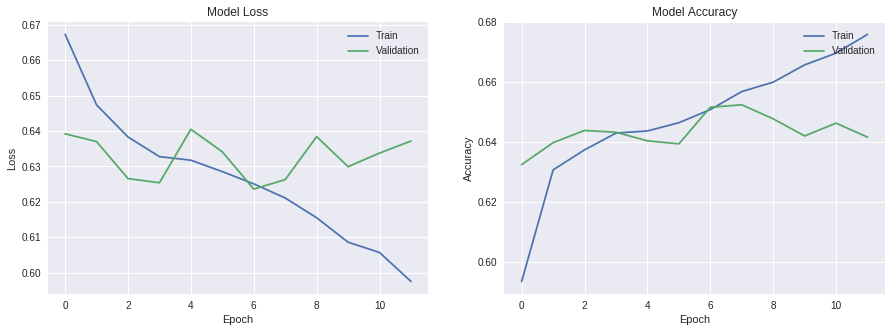

In [0]:
print_model_history(trained_model)


In [0]:
Y_pred = model.predict(rev_test)
print(Y_pred[:3])

[[0.9999063 ]
 [0.99990654]
 [0.9999062 ]]


In [0]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_recall_fscore_support

print("Mean squared error: %.2f" % mean_squared_error(help_test, Y_pred))

print("R2: %.2f" % r2_score(help_test, Y_pred))

print("accuracy: %.2f" % accuracy_score(help_test, Y_pred>0.5))

print("P R F1")
print(precision_recall_fscore_support(help_test, Y_pred>0.5))


Mean squared error: 0.22
R2: 0.09
accuracy: 0.65
P R F1
(array([0.60555121, 0.68107053]), array([0.57519495, 0.70770568]), array([0.58998286, 0.69413269]), array([2693, 3452]))


In [0]:
from sklearn import datasets, linear_model

regr = linear_model.LogisticRegression()

regr.fit(rat_train,help_train)


# Make predictions using the testing set
y_pred = regr.predict(rat_test)

print("Mean squared error: %.2f" % mean_squared_error(help_test, y_pred))

print("R2: %.2f" % r2_score(help_test, y_pred))

print("accuracy: %.2f" % accuracy_score(help_test, y_pred>0.5))

print("P R F1")
print(precision_recall_fscore_support(help_test, y_pred>0.5))


Mean squared error: 0.38
R2: -0.55
accuracy: 0.62
P R F1
(array([0.5604547 , 0.67119062]), array([0.60415893, 0.63035921]), array([0.58148678, 0.65013445]), array([2693, 3452]))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
Y_rev_train = model.predict(rev_train)
Y_rat_train = np.expand_dims(regr.predict(rat_train), axis = 1)

Y_rev_test = model.predict(rev_test)
Y_rat_test = np.expand_dims(regr.predict(rat_test), axis = 1)

# print(Y_rat_train.shape)
# print(Y_rev_train.shape)
Y_train = np.hstack((Y_rat_train, Y_rev_train))
Y_test = np.hstack((Y_rat_test, Y_rev_test))

regr2 = linear_model.LogisticRegression()

regr2.fit(Y_train,help_train)


# Make predictions using the testing set
y_pred = regr2.predict(Y_test)

print("Mean squared error: %.2f" % mean_squared_error(help_test, y_pred))

print("R2: %.2f" % r2_score(help_test, y_pred))

print("accuracy: %.2f" % accuracy_score(help_test, y_pred>0.5))

print("P R F1")
print(precision_recall_fscore_support(help_test, y_pred>0.5))


Mean squared error: 0.34
R2: -0.40
accuracy: 0.66
P R F1
(array([0.61184723, 0.6862252 ]), array([0.58299294, 0.71147161]), array([0.59707169, 0.6986204 ]), array([2693, 3452]))


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
